In [1]:
# Import necessary packages:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import timeit
import math
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras import initializers

In [2]:
train = pd.read_csv('mnist_train.csv')
test = pd.read_csv('mnist_test.csv')

In [3]:
# Convert to Numpy array: 
X = np.array(train.drop(['label'],axis = 1)).T
X_test = np.array(test.drop(['label'],axis = 1)).T
labels = np.array(train['label'])
labels_test = np.array(test['label'])

In [4]:
# Retrieve constants: 
m = X.shape[1]
num_px = X.shape[0]
num_labels = len(np.unique(labels))
m_test = X_test.shape[1]

In [5]:
# Create a one hot function to convert the labels:
def one_hot(labels,num_labels):    
    y = np.zeros((num_labels,len(labels)))
    for i in range(len(labels)):
        y[labels[i]][i] = 1
    return(y)

y = one_hot(labels,num_labels)
y_test = one_hot(labels_test,num_labels)

In [6]:
# Explore the dataset:
print ("Number of training examples: " + str(m))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(int(np.sqrt(num_px))) + ", " + str(int(np.sqrt(num_px))) + ", 1)")
print ("Number of unique labels: " + str(num_labels))
print ("X shape: " + str(X.shape))
print ("y shape: " + str(y.shape))
print ("X_test shape: " + str(X_test.shape))
print ("y_test shape: " + str(y_test.shape))

Number of training examples: 60000
Number of testing examples: 10000
Each image is of size: (28, 28, 1)
Number of unique labels: 10
X shape: (784, 60000)
y shape: (10, 60000)
X_test shape: (784, 10000)
y_test shape: (10, 10000)


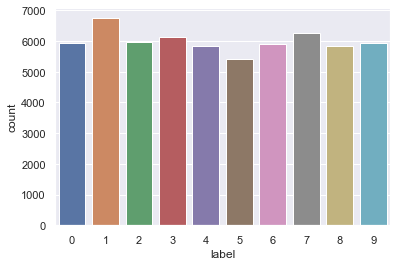

In [7]:
# We can see that the label probabilitiy is almost uniform.. 
sns.set(style = "darkgrid")
sns.countplot(x = 'label', data = train)
plt.show()

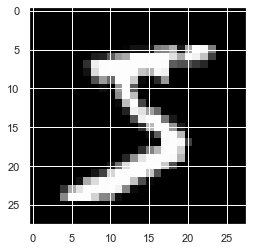

In [349]:
example = X[:,0]
example = np.reshape(example, (28,28))
plt.imshow(example,cmap='gray')
plt.show()

### In this project we will explore different algorithms for classifying the Mnist dataset. 
 - The first algorithm will be a Step-by-Step Neural Network that will be built from scratch. 
 - Later we will try another Neural Network using the Keras package.
 - And lastly we will use Conv-Nets using Keras package. 

## Step-by-Step NN:

### Initialization: 

In [9]:
# Standardize data to have feature values between 0 and 1.

X = X/255.
X_test = X_test/255.

In [10]:
# Define the size and number of layers in the Network:

layers_dims = [num_px, 30, 20, num_labels] #  3-layer model

In [11]:
# Initialize the parameters W and b according to the number of nodes and layers:
# for an L layers model we have L matrices of weights W in the size of [l x l-i]
# and L vectors of bayeses b in the size of [l x 1]
# The weight matrices are initialized with small random numbers and the biases are 
# initialized with zeros: 
# The function outputs a dict with the parameters. 

def initialize_parameters(layer_dims, initialization):
  
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        
        if initialization == 'random':
            
            parameters["W" + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.05
            parameters["b" + str(l)] = np.zeros((layer_dims[l], 1))
        
        if initialization == 'he':
            
            parameters['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l-1])*np.sqrt(2./layers_dims[l-1])
            parameters['b' + str(l)] = np.zeros((layers_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

### Forward Propagation: 

#### Linear Forward: 
The linear forward module (vectorized over all the examples) computes the following equations:

$$Z^{[l]} = W^{[l]}A^{[l-1]} +b^{[l]}\tag{4}$$

where $A^{[0]} = X$. 

In [12]:
# Linear Forward
def linear_forward(A, W, b):

    Z = np.dot(W,A)+b

    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

#### Activation Functions:

In [13]:
# Implement the RELU function
def relu(Z):
  
    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)   
    
    cache = Z 
    return A, cache

In [14]:
# Implement the softmax function
def softmax(Z):
    
    t = np.exp(Z)
    A = t / np.sum(t, axis = 0)
    
    assert(A.shape == Z.shape)   
    
    cache = Z 
    return A, cache

#### Activation of a single layer: 

In [15]:
def linear_activation_forward(A_prev, W, b, activation):

    Z, linear_cache = linear_forward(A_prev, W, b)
        
    if activation == "relu":
        A, activation_cache = relu(Z)
        
    elif activation == "softmax":
        A, activation_cache = softmax(Z)
   
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

#### Forward Propagation for a network with L layers:

  Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SOFTMAX computation
    
    Arguments:
    X: data, numpy array of shape (input size, number of examples)
    parameters: output of initialize_parameters()
    
    Returns:
    AL: last post-activation value
    caches: list of caches containing:
            every cache of linear_activation_forward() (there are L-1 of them, indexed from 0 to L-1)

In [16]:
def L_model_forward(X, parameters):

    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters["W" + str(l)], parameters["b" + str(l)], activation = "relu")
        caches.append(cache)
    
    # Implement LINEAR -> SOFTMAX. Add "cache" to the "caches" list.
    AL, cache = linear_activation_forward(A, parameters["W" + str(L)], parameters["b" + str(L)], activation = "softmax")
    caches.append(cache)
    
    assert(AL.shape[1] == X.shape[1])
            
    return AL, caches

### Cost Function:

In [17]:
# Compute the softmax cost function
def compute_cost(AL, Y):
    
    m = Y.shape[1]

    cost = (1/m)*np.sum(-np.multiply(Y,np.log(AL)))
    
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())
    
    return cost

### Backward Propagation:
#### Linear backward:

Implement the linear portion of backward propagation for a single layer (layer l):

    Arguments:
    dZ: Gradient of the cost with respect to the linear output (of current layer l)
    cache: tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev: Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW: Gradient of the cost with respect to W (current layer l), same shape as W
    db: Gradient of the cost with respect to b (current layer l), same shape as b

In [18]:
def linear_backward(dZ, cache):

    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (1/m)*np.dot(dZ,A_prev.T)
    db = (1/m)*np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T,dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

#### Relu Backprop:

Implement the backward propagation for a single RELU unit:

In [19]:
def relu_backward(dA, cache):

    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

#### Linear-Activation backward:

Implement the backward propagation for the LINEAR->ACTIVATION layer:
    
    Arguments:
    dA: post-activation gradient for current layer l 
    cache: tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation: the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev: Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW: Gradient of the cost with respect to W (current layer l), same shape as W
    db: Gradient of the cost with respect to b (current layer l), same shape as b

In [20]:
def linear_activation_backward(dA, cache, activation):
 
    linear_cache, activation_cache = cache
    
    if activation == "relu":

        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "softmax":
        
        dZ = dA
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    
    return dA_prev, dW, db

#### L-Model Backward: 

Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL: probability vector, output of the forward propagation (L_model_forward())
    Y: true "label" vector (containing 0 if non-cat, 1 if cat)
    caches: list of caches containing:
                every cache of linear_activation_forward() with "relu" (it's caches[l], for l in range(L-1) i.e l = 0...L-2)
                the cache of linear_activation_forward() with "sigmoid" (it's caches[L-1])
    
    Returns:
    grads: A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ...

In [21]:
def L_model_backward(AL, Y, caches):

    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation:
    dAL = AL - Y
    
    # Lth layer (SOFTMAX -> LINEAR) gradients. Inputs: "dAL, current_cache". Outputs: "grads["dAL-1"], grads["dWL"], grads["dbL"]
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "softmax")
    
    # Loop from l=L-2 to l=0
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        # Inputs: "grads["dA" + str(l + 1)], current_cache". Outputs: "grads["dA" + str(l)] , grads["dW" + str(l + 1)] , grads["db" + str(l + 1)] 
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l+1)], current_cache, activation = "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

### Update Parameters: 

In [22]:
def update_parameters(parameters, grads, learning_rate):

    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*grads["dW" + str(l + 1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*grads["db" + str(l + 1)]

    return parameters

### L-layer Neural Network Basic Model Implementation:

In [23]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost = False, initialization = 'random'):

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization. 
    parameters = initialize_parameters(layers_dims, initialization)
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)
        
        # Compute cost.
        cost = compute_cost(AL, Y)
    
        # Backward propagation.
        grads = L_model_backward(AL, Y, caches)
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
                        
        # Print the cost every 100 training example
        if print_cost and i % 1 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters, costs

#### Predict function: 

Turn the probabilities of the softmax output to predicted labels

In [24]:
def predict(X, labels, parameters):
  
    m = X.shape[1]
    
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)
   
    # convert probas to 0/1 predictions
    labels_hat = np.argmax(probas,axis = 0)
    
    accuracy = np.sum((labels == labels_hat)/m)
        
    return labels_hat, accuracy

### Mini Batch Gradient Descent:

There are two steps:
- **Shuffle**: Create a shuffled version of the training set (X, Y) as shown below. Each column of X and Y represents a training example. Note that the random shuffling is done synchronously between X and Y. Such that after the shuffling the $i^{th}$ column of X is the example corresponding to the $i^{th}$ label in Y. The shuffling step ensures that examples will be split randomly into different mini-batches. 

<img src="kiank_shuffle.png" style="width:550px;height:300px;">

- **Partition**: Partition the shuffled (X, Y) into mini-batches of size `mini_batch_size` (here 64). Note that the number of training examples is not always divisible by `mini_batch_size`. The last mini batch might be smaller, but you don't need to worry about this. When the final mini-batch is smaller than the full `mini_batch_size`, it will look like this: 

<img src="kiank_partition.png" style="width:550px;height:300px;">



Note that the last mini-batch might end up smaller than `mini_batch_size=64`. Let $\lfloor s \rfloor$ represents $s$ rounded down to the nearest integer (this is `math.floor(s)` in Python). If the total number of examples is not a multiple of `mini_batch_size=64` then there will be $\lfloor \frac{m}{mini\_batch\_size}\rfloor$ mini-batches with a full 64 examples, and the number of examples in the final mini-batch will be ($m-mini_\_batch_\_size \times \lfloor \frac{m}{mini\_batch\_size}\rfloor$). 

In [25]:
# This function takes X and y and shuffle them and then divide them into unique mini batches. 
# For each epoch the data sets will be shuffled differently, so that in each epoch every batch will contain different examples
# but in the overall, each epoch contains exactly all the examples without repetitions. 
# The different shuffle is held by a different seed that will be updated in the main script along the loop over the number of 
# iterations. 

def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
   
    np.random.seed(seed)            
    m = X.shape[1]                  # number of training examples
    mini_batches = []
        
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation]

    # Step 2: Creating the Mini Batches: (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
       
        mini_batch_X = shuffled_X[:, k*mini_batch_size : (k+1)* mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k*mini_batch_size : (k+1)* mini_batch_size]
      
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        
        mini_batch_X = shuffled_X[:,num_complete_minibatches*mini_batch_size ::]
        mini_batch_Y = shuffled_Y[:,num_complete_minibatches*mini_batch_size ::]
        
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [26]:
# Compute the softmax cost function for Mini-Batch 
def compute_cost_MB(AL, Y):
    
    m = Y.shape[1]

    cost = np.sum(-np.multiply(Y,np.log(AL)))  # Summation is done after the whole epoch
    
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())
    
    return cost

### Adam

Adam is one of the most effective optimization algorithms for training neural networks. It combines ideas from RMSProp and Momentum. 

**How does Adam work?**
1. It calculates an exponentially weighted average of past gradients, and stores it in variables $v$ (before bias correction) and $v^{corrected}$ (with bias correction). 
2. It calculates an exponentially weighted average of the squares of the past gradients, and  stores it in variables $s$ (before bias correction) and $s^{corrected}$ (with bias correction). 
3. It updates parameters in a direction based on combining information from "1" and "2".

The update rule is, for $l = 1, ..., L$: 

$$\begin{cases}
v_{dW^{[l]}} = \beta_1 v_{dW^{[l]}} + (1 - \beta_1) \frac{\partial \mathcal{J} }{ \partial W^{[l]} } \\
v^{corrected}_{dW^{[l]}} = \frac{v_{dW^{[l]}}}{1 - (\beta_1)^t} \\
s_{dW^{[l]}} = \beta_2 s_{dW^{[l]}} + (1 - \beta_2) (\frac{\partial \mathcal{J} }{\partial W^{[l]} })^2 \\
s^{corrected}_{dW^{[l]}} = \frac{s_{dW^{[l]}}}{1 - (\beta_2)^t} \\
W^{[l]} = W^{[l]} - \alpha \frac{v^{corrected}_{dW^{[l]}}}{\sqrt{s^{corrected}_{dW^{[l]}}} + \varepsilon}
\end{cases}$$
where:
- t counts the number of steps taken of Adam 
- L is the number of layers
- $\beta_1$ and $\beta_2$ are hyperparameters that control the two exponentially weighted averages. 
- $\alpha$ is the learning rate
- $\varepsilon$ is a very small number to avoid dividing by zero
 

#### Adam Initialization:

In [27]:
# Initialize Adam parameters to zeros in the shapes of the weights:

def initialize_adam(parameters):
       
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    s = {}
    
    # Initialize v, s. Input: "parameters". Outputs: "v, s".
    for l in range(L):
        v["dW" + str(l+1)] = np.zeros(parameters['W' + str(l+1)].shape)
        v["db" + str(l+1)] = np.zeros(parameters['b' + str(l+1)].shape)
        s["dW" + str(l+1)] = np.zeros(parameters['W' + str(l+1)].shape)
        s["db" + str(l+1)] = np.zeros(parameters['b' + str(l+1)].shape)
    
    return v, s

#### Adam updating gradient descent parameters: 

In [28]:
def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate = 0.01,
                                beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):
    
    L = len(parameters) // 2                 # number of layers in the neural networks
    v_corrected = {}                         # Initializing first moment estimate, python dictionary
    s_corrected = {}                         # Initializing second moment estimate, python dictionary
    
    # Perform Adam update on all parameters
    for l in range(L):
        # Moving average of the gradients. Inputs: "v, grads, beta1". Output: "v".
        v["dW" + str(l+1)] = beta1*v["dW" + str(l+1)] + (1-beta1)*grads["dW" + str(l+1)]
        v["db" + str(l+1)] = beta1*v["db" + str(l+1)] + (1-beta1)*grads["db" + str(l+1)]

        # Compute bias-corrected first moment estimate. Inputs: "v, beta1, t". Output: "v_corrected".
        v_corrected["dW" + str(l+1)] = v["dW" + str(l+1)]/(1-(beta1)**t)
        v_corrected["db" + str(l+1)] = v["db" + str(l+1)]/(1-(beta1)**t)

        # Moving average of the squared gradients. Inputs: "s, grads, beta2". Output: "s".
        s["dW" + str(l+1)] = beta2*s["dW" + str(l+1)] + (1-beta2)*(grads["dW" + str(l+1)]**2)
        s["db" + str(l+1)] = beta2*s["db" + str(l+1)] + (1-beta2)*(grads["db" + str(l+1)]**2)

        # Compute bias-corrected second raw moment estimate. Inputs: "s, beta2, t". Output: "s_corrected".
        s_corrected["dW" + str(l+1)] = s["dW" + str(l+1)]/(1-(beta2)**t)
        s_corrected["db" + str(l+1)] = s["db" + str(l+1)]/(1-(beta2)**t)

        # Update parameters. Inputs: "parameters, learning_rate, v_corrected, s_corrected, epsilon". Output: "parameters".
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*(v_corrected["dW" + str(l+1)]/(np.sqrt(s_corrected["dW" + str(l+1)])+epsilon))
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*(v_corrected["db" + str(l+1)]/(np.sqrt(s_corrected["db" + str(l+1)])+epsilon))
        
    return parameters, v, s

### L-layer Neural Network with Mini Batch and Adam:

In [29]:
def L_layer_model_Mini_batch_Adam(X, Y, X_test, Y_test, layers_dims, optimizer = 'gd', initialization = 'random', 
                                  learning_rate = 0.2, mini_batch_size = 64, beta1 = 0.9, beta2 = 0.999,
                                  epsilon = 1e-8, num_epochs = 100, print_cost = True):

    L = len(layers_dims)             # number of layers in the neural networks
    costs = []                       # to keep track of the cost
    t = 0                            # initializing the counter required for Adam update
    seed = 0                        
    m = X.shape[1]                   # number of training examples
    test_costs = []
    
    # Initialize parameters
    parameters = initialize_parameters(layers_dims, initialization)

    # Initialize the optimizer
    if optimizer == "gd":
        pass # no initialization required for gradient descent
    
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)
    
    # Optimization loop
    for i in range(num_epochs):
        
        # Define the random minibatches. We increment the seed to reshuffle differently the dataset after each epoch
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)
        cost_total = 0
        
        for minibatch in minibatches:

            # Select a minibatch
            (minibatch_X, minibatch_Y) = minibatch

            # Forward propagation
            AL, caches = L_model_forward(minibatch_X, parameters)

            # Compute cost and add to the cost total
            cost_total += compute_cost_MB(AL, minibatch_Y)

            # Backward propagation
            grads = L_model_backward(AL, minibatch_Y, caches)

            # Update parameters
            if optimizer == "gd":
                parameters = update_parameters(parameters, grads, learning_rate)
            
            elif optimizer == "adam":
                t = t + 1 # Adam counter
                parameters, v, s = update_parameters_with_adam(parameters, grads, v, s,
                                                               t, learning_rate, beta1, beta2,  epsilon)        
        
        cost_avg = cost_total / m
        
        # Save the cost every 100 epoch
        if print_cost and i % 1 == 0:
            #print("Cost after iteration %i: %f" %(i, cost_avg))
            costs.append(cost_avg)           
            AL_test, _ = L_model_forward(X_test, parameters)
            cost_test = compute_cost(AL_test, y_test)
            test_costs.append(cost_test)
                

    return parameters, costs, test_costs

In [30]:
# Let's check the network with different Batch sizes and different Learning rate: 

results = {}
weights = {}
index = 1
hyp = {'Mb_size' : [128,1024,8192], 'Lr' : [0.1,0.2,0.3]}


for mb_size in hyp['Mb_size']:
    for Lr in hyp['Lr']:

        tic = timeit.default_timer() # Start clock

        parameters, costs, test_costs = L_layer_model_Mini_batch_Adam(X, y, X_test, y_test, layers_dims,
                                          optimizer = 'gd' , mini_batch_size = mb_size ,learning_rate = Lr)

        toc = timeit.default_timer() # Stop clock

        duration = toc - tic

        _, accuracy = predict(X, labels, parameters)
        _, accuracy_test = predict(X_test, labels_test, parameters)

        results['Run ' + str(index)] = {'Mb_size' : mb_size, 'Lr': Lr,'train_costs' : costs, 
                                        'test_costs' : test_costs, 'train_acc': accuracy, 'test_acc' : accuracy_test}
        weights['Run ' + str(index)] = parameters

        index = index+1                                                              

with open("results.txt", "w") as file:
    file.write(str(results))

with open("weights.txt", "w") as file:
    file.write(str(weights))
    

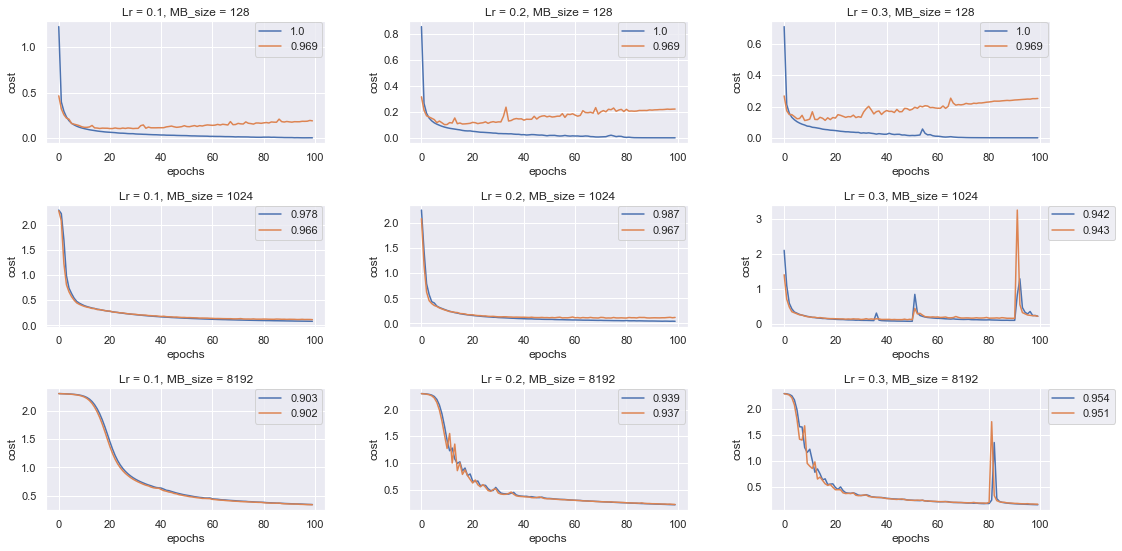

In [31]:
# Plot the results and discuss them:

sns.set(style = "darkgrid")
fig = plt.figure(figsize = (18, 9))
fig.subplots_adjust(hspace = 0.5, wspace = 0.3)

for i in range(len(results)):

    ax = fig.add_subplot(3,3, i + 1)
    plt.plot(results['Run ' + str(i+1)]['train_costs'], label = str(round(results['Run ' + str(i+1)]['train_acc'],3)))
    plt.plot(results['Run ' + str(i+1)]['test_costs'], label = str(round(results['Run ' + str(i+1)]['test_acc'],3)))
    plt.legend(bbox_to_anchor=(0.99, 0.99), borderaxespad=0)
    plt.ylabel('cost')
    plt.xlabel('epochs')
    plt.title("Lr = " + str(results['Run ' + str(i+1)]['Lr']) + ', MB_size = ' + str(results['Run ' + str(i+1)]['Mb_size']))

#### Discussion:

1. Small mini batch size converge faster
2. Small mini batch size achives higher accuracy in both train and test sets, but, also creates overfitting
3. Large Lr creates sensitivity in the Gradient descend, and therefore we witness bumps in the graph which point in instability of the minimazation. 

#### Conclusion:

For now the best setting in terms of convergenge, computational speed, generalization, and accuracy was achieved with LR = 0.1 and batch size of 1024. 

We can perhaps improve the model with different hyperparameters but for now the result are sufficient enougth, so lets continue with building a model with Keras package: 

### Keras fully connected model: 

Let's build a Keras sequential model with the same hyperparameters as example 4 (lr = 0.1, MB_size = 1024) with 100 epochs.

In [32]:
# Preparing the datasets for Keras models:
X_keras = X.T
y_keras = y.T

X_test_keras = X_test.T
y_test_keras = y_test.T

# Define a simple 3 layer sequential model like in L_layer_model:
input_shape = layers_dims[0] 

# Set up the model: model
model = Sequential()

# Add the first layer
model.add(Dense(layers_dims[1], activation = 'relu', input_shape = (input_shape,), 
                kernel_initializer = initializers.RandomNormal(stddev=0.05)))

# Add the second layer
model.add(Dense(layers_dims[2], activation = 'relu',kernel_initializer = initializers.RandomNormal(stddev=0.05)))

# Add the output layer
model.add(Dense(layers_dims[3], activation = 'softmax',kernel_initializer = initializers.RandomNormal(stddev=0.05)))

# Choose optimizer
opt = keras.optimizers.SGD(learning_rate = 0.1, momentum = 0.0, name = "SGD")

# Compile the model
model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Fit the model
Callback = model.fit(X_keras, y_keras, batch_size = 1024, epochs = 100,
                     validation_data = (X_test_keras,y_test_keras), verbose = 0)


In [33]:
# Model summary: number of parameters and architecture
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                23550     
_________________________________________________________________
dense_1 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                210       
Total params: 24,380
Trainable params: 24,380
Non-trainable params: 0
_________________________________________________________________


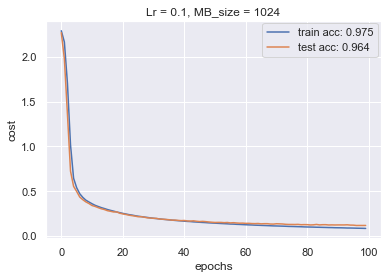

In [34]:
# Plotting:
def plot_loss(Callback):
    plt.plot(Callback.history['loss'], label = 'train acc: ' + str(round(Callback.history['accuracy'][-1],3)))
    plt.plot(Callback.history['val_loss'], label = 'test acc: ' + str(round(Callback.history['val_accuracy'][-1],3)))
    plt.legend(bbox_to_anchor=(0.99, 0.99), borderaxespad=0)
    plt.ylabel('cost')
    plt.xlabel('epochs')
    
plot_loss(Callback)
plt.title("Lr = 0.1, MB_size = 1024")
plt.show()

As we can see, the keras model gave as almost the same result for the same hyperparameters, there is a slight difference in the final accuracy in both train and test sets, but it is probably because of the initialization of the weights. 

#### Batch Normalization:

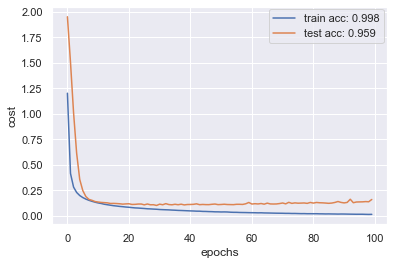

In [35]:
## Adding Batch normalization for improving of the gradient descent:
from keras.layers import BatchNormalization

# Set up the model:
batch_model = Sequential()

# Add the first layer
batch_model.add(Dense(layers_dims[1], activation = 'relu', input_shape = (input_shape,), 
                kernel_initializer = initializers.RandomNormal(stddev=0.05)))

# Add a batch normalization layer after every layer:
batch_model.add(BatchNormalization())

# Add the second layer
batch_model.add(Dense(layers_dims[2], activation = 'relu',kernel_initializer = initializers.RandomNormal(stddev=0.05)))
batch_model.add(BatchNormalization())

# Add the output layer
batch_model.add(Dense(layers_dims[3], activation = 'softmax',kernel_initializer = initializers.RandomNormal(stddev=0.05)))

# Choose optimizer
opt = keras.optimizers.SGD(learning_rate = 0.1, momentum = 0.0, name = "SGD")

# Compile the model
batch_model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Fit the model
batch_Callback = batch_model.fit(X_keras, y_keras, batch_size = 1024, epochs = 100,
                     validation_data = (X_test_keras,y_test_keras), verbose = 0)

plot_loss(batch_Callback)

We can see improvement in the train accuracy, but also more overfitting. les't try to adress the problem with dropout.

In [36]:
from keras.layers import Dropout

def Drop_model(drop):
    # Set up the model: 
    drop_model = Sequential()

    # Add the first layer
    drop_model.add(Dense(layers_dims[1], activation = 'relu', input_shape = (input_shape,), 
                    kernel_initializer = initializers.RandomNormal(stddev=0.05)))

    # Add a batch normalization layer after every layer:
    drop_model.add(BatchNormalization())

    # Add Dropout
    drop_model.add(Dropout(drop))

    # Add the second layer
    drop_model.add(Dense(layers_dims[2], activation = 'relu',kernel_initializer = initializers.RandomNormal(stddev=0.05)))
    drop_model.add(BatchNormalization())
    drop_model.add(Dropout(drop))

    # Add the output layer
    drop_model.add(Dense(layers_dims[3], activation = 'softmax',kernel_initializer = initializers.RandomNormal(stddev=0.05)))

    # Choose optimizer
    opt = keras.optimizers.SGD(learning_rate = 0.1, momentum = 0.0, name = "SGD")

    # Compile the model
    drop_model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

    # Fit the model
    drop_Callback = drop_model.fit(X_keras, y_keras, batch_size = 1024, epochs = 100,
                         validation_data = (X_test_keras,y_test_keras), verbose = 0)

    return drop_Callback

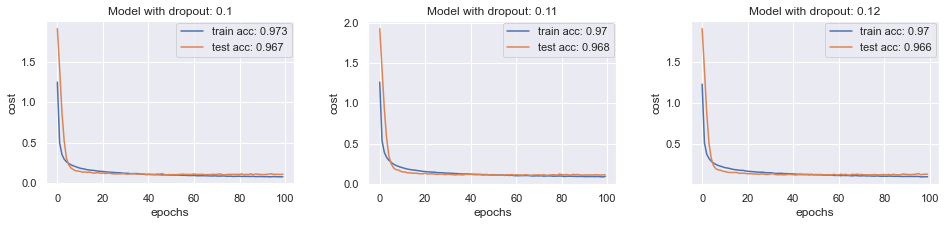

In [37]:
# Explore different values of dropout percentages: 

drops = [0.1, 0.11, 0.12]

fig = plt.figure(figsize = (16, 3))
fig.subplots_adjust(hspace = 1, wspace = 0.3)

for i, drop in enumerate(drops):
    
    drop_Callback = Drop_model(drop)
    ax = fig.add_subplot(1,3, i + 1)
    plot_loss(drop_Callback)
    plt.title("Model with dropout: " + str(drop))

### Keras Conv-Net model:

Lets build a Convolutional Network for the same data set with keras' convolution package

In [38]:
# In image algorithms the input of a convnets are matrices displaying an image. 
# Before building the network, there is a need to reshpe the data sets.

img_size = int(np.sqrt(num_px))
X_conv = np.reshape(X_keras,(m,img_size,img_size,1))
X_conv_test = np.reshape(X_test_keras,(m_test,img_size,img_size,1))

The following script models a basic Conv-Net to adress the above dataset problem. 
This model is referred as the default model, and afterwards we will explore different sets of hyperparameters to understand the 
behavior under these certain changes.

In [39]:
from keras.layers import Conv2D, Flatten

# Initialize the model object
conv_model = Sequential()

# Add a convolutional layer
conv_model.add(Conv2D(10, kernel_size = 3, activation = 'relu', 
               input_shape = (img_size, img_size, 1), padding = 'same'))

# Flatten the output of the convolutional layer
conv_model.add(Flatten())

# Add an output layer for the 3 categories
conv_model.add(Dense(10, activation='softmax'))

# Compile model
conv_model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Fit model
conv_Callback = conv_model.fit(X_conv, y_keras, batch_size = 1024, epochs = 100,
                         validation_data = (X_conv_test, y_test_keras), verbose = 2)

Epoch 1/100
59/59 - 6s - loss: 0.7142 - accuracy: 0.8144 - val_loss: 0.3324 - val_accuracy: 0.9079
Epoch 2/100
59/59 - 6s - loss: 0.3217 - accuracy: 0.9082 - val_loss: 0.2890 - val_accuracy: 0.9163
Epoch 3/100
59/59 - 6s - loss: 0.2893 - accuracy: 0.9173 - val_loss: 0.2714 - val_accuracy: 0.9208
Epoch 4/100
59/59 - 6s - loss: 0.2693 - accuracy: 0.9235 - val_loss: 0.2565 - val_accuracy: 0.9276
Epoch 5/100
59/59 - 6s - loss: 0.2494 - accuracy: 0.9296 - val_loss: 0.2377 - val_accuracy: 0.9337
Epoch 6/100
59/59 - 6s - loss: 0.2281 - accuracy: 0.9353 - val_loss: 0.2205 - val_accuracy: 0.9380
Epoch 7/100
59/59 - 6s - loss: 0.2089 - accuracy: 0.9410 - val_loss: 0.2059 - val_accuracy: 0.9417
Epoch 8/100
59/59 - 6s - loss: 0.1887 - accuracy: 0.9472 - val_loss: 0.1791 - val_accuracy: 0.9505
Epoch 9/100
59/59 - 6s - loss: 0.1681 - accuracy: 0.9538 - val_loss: 0.1650 - val_accuracy: 0.9550
Epoch 10/100
59/59 - 6s - loss: 0.1517 - accuracy: 0.9583 - val_loss: 0.1510 - val_accuracy: 0.9581
Epoch 11/

59/59 - 6s - loss: 0.0102 - accuracy: 0.9984 - val_loss: 0.0813 - val_accuracy: 0.9793
Epoch 84/100
59/59 - 6s - loss: 0.0099 - accuracy: 0.9985 - val_loss: 0.0816 - val_accuracy: 0.9796
Epoch 85/100
59/59 - 6s - loss: 0.0098 - accuracy: 0.9985 - val_loss: 0.0819 - val_accuracy: 0.9795
Epoch 86/100
59/59 - 6s - loss: 0.0095 - accuracy: 0.9987 - val_loss: 0.0832 - val_accuracy: 0.9795
Epoch 87/100
59/59 - 6s - loss: 0.0092 - accuracy: 0.9987 - val_loss: 0.0845 - val_accuracy: 0.9792
Epoch 88/100
59/59 - 5s - loss: 0.0090 - accuracy: 0.9988 - val_loss: 0.0841 - val_accuracy: 0.9790
Epoch 89/100
59/59 - 6s - loss: 0.0086 - accuracy: 0.9988 - val_loss: 0.0865 - val_accuracy: 0.9792
Epoch 90/100
59/59 - 5s - loss: 0.0083 - accuracy: 0.9989 - val_loss: 0.0845 - val_accuracy: 0.9798
Epoch 91/100
59/59 - 6s - loss: 0.0082 - accuracy: 0.9988 - val_loss: 0.0867 - val_accuracy: 0.9795
Epoch 92/100
59/59 - 6s - loss: 0.0080 - accuracy: 0.9990 - val_loss: 0.0872 - val_accuracy: 0.9800
Epoch 93/100


#### Conv-Net with different parameters model: 

In [168]:
def Conv_model(num_filters = 10, f = 3, act = 'relu', pad = 'same', stride = 1, opt = 'Adam', mb_size = 1024, drop = False):
    
    # Start clock
    tic = timeit.default_timer() 
    
    # Initialize the model object
    conv_model = Sequential()

    # Add a convolutional layer: 
    conv_model.add(Conv2D(num_filters, kernel_size = f, activation = act, 
                   input_shape = (img_size, img_size, 1), padding = pad, strides = stride)) 
    
    # Add dropuot if requested: 
    if drop != False: 
        conv_model.add(Dropout(drop))
    
    # Flatten the output of the convolutional layer
    conv_model.add(Flatten())

    # Add an output layer for the 3 categories
    conv_model.add(Dense(10, activation='softmax'))

    # Compile model
    conv_model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

    # Fit model
    conv_Callback = conv_model.fit(X_conv, y_keras, batch_size = mb_size, epochs = 100,
                             validation_data = (X_conv_test, y_test_keras), verbose = 0)
    
    # Stop clock
    toc = timeit.default_timer() 
    duration = toc - tic
    
    return (conv_Callback, duration)

Before comparing different hyperparameters we will first run the model with the default parameters:

In [170]:
default_hyp = {'num_filters': 10, 'f': 3, 'pad': 'same', 'stride': 1, 'opt': 'Adam', 'mb_size': 1024, 'drop': False}
default = Conv_model()

#### Hyperparameters behavior: 

Let's build a function that will compute the runs with different hyperparameteres and plot thier loss plots: 

In [167]:
def plot_loss_compare(dic,hyperparams,duration_dic,compare):
    # First plot:
    sns.set_palette("Set2",color_codes=True)
    fig = plt.figure(figsize = (16, 3))
    fig.subplots_adjust(hspace = 1, wspace = 0.3)

    # Define plot boundaries by the highest pick
    y_max = []
    for hyperparam in(hyperparams):
        y_max.append(np.max(dic[str(hyperparam)].history['loss']))
    y_max = np.max(y_max)
    x_max = len(dic[str(hyperparam)].history['loss']) 

    for i, hyperparam in enumerate(hyperparams):

        ax = fig.add_subplot(1,3, i + 1)
        ax.set(xlim=(-0.1,x_max), ylim=(-0.1,y_max))

        plot_loss(dic[str(hyperparams[i])])
        if hyperparam == default_hyp[hyp_exp]: 
            plt.title(compare + str(hyperparams[i]) + ',  Time: ' + str(round(duration_dic[str(hyperparams[i])],3)) + '(Default)')
        else: 
            plt.title(compare + str(hyperparams[i]) + ',  Time: ' + str(round(duration_dic[str(hyperparams[i])],3)))

    # Second plot:
    sns.set_palette('tab10',color_codes=True)
    fig = plt.figure(figsize = (6, 5))
    fig.subplots_adjust(hspace = 1, wspace = 0.3)

    for i in (hyperparams):
        plot = dic[str(i)].history['loss']
        plt.plot(plot, label = compare + str(i))

    plt.title('Loss')
    plt.legend(bbox_to_anchor=(0.99, 0.99), borderaxespad=0)
    plt.ylabel('cost')
    plt.xlabel('epochs')

In [202]:
def Hyperparam_explore(hyperparams, hyp_exp, default_model, default_hyp):
    
    # Initialize Dictionaries:
    dic = {}
    duration_dic = {}
    
    # Make a copy for defoult_hyp
    model_hyp = default_hyp.copy()
  
    for hyperparam in hyperparams: 
        
        model_hyp[hyp_exp] = hyperparam
        
        if hyperparam == default_hyp[hyp_exp]:
            Callback, duration = default

        else:
            Callback, duration = Conv_model(num_filters = model_hyp['num_filters'], f = model_hyp['f'], 
                                        act = 'relu', pad = model_hyp['pad'], stride = model_hyp['stride'],
                                        opt = model_hyp['opt'], mb_size = model_hyp['mb_size'],
                                        drop = model_hyp['drop'])
        
        dic[str(hyperparam)] = Callback
        duration_dic[str(hyperparam)] = duration
                    
    return dic, duration_dic


#### Number of filters (or NF):

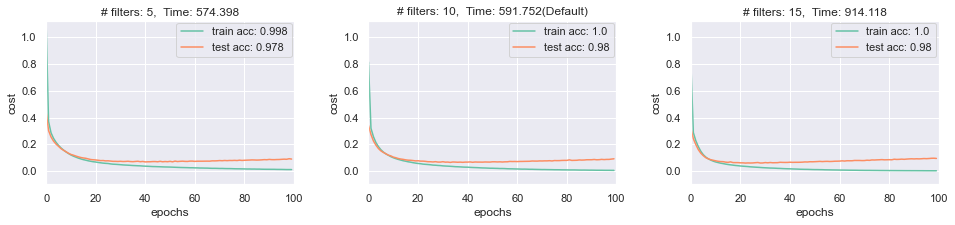

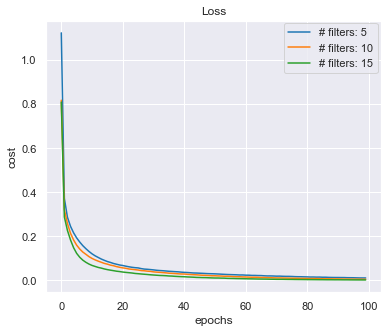

In [142]:
# Define hyperparameter set:
num_filters = [5, 10, 15]

# Run algorithm for comparison: 
NF_dic, NF_dic_durarion = Hyperparam_explore(hyperparams = num_filters, hyp_exp = 'num_filters', 
                                             default_model = default, default_hyp = default_hyp)

# Plot runs with different hyperparameters:
plot_loss_compare(NF_dic, num_filters_set, NF_dic_durarion, compare = "# filters: ")

##### Discussion: 
More filters results in more extructed features, and therefore with more weights, so the training will be more accurate but also will result in high computational cost. In this run we can see that 5 filters results in poorer accuracy then 10 and 15, but 15 filters are very expensive computationally. We can also see an increasment in the overfitting along the increasment of the number of filters. 
##### Conclusion: 
Let's stay with the default settings for the number of filters. 

#### Filter size or (FS):

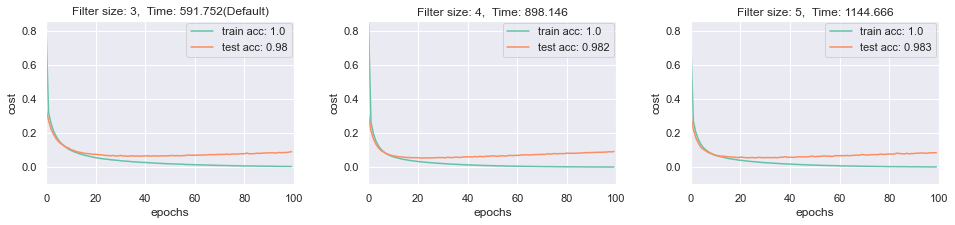

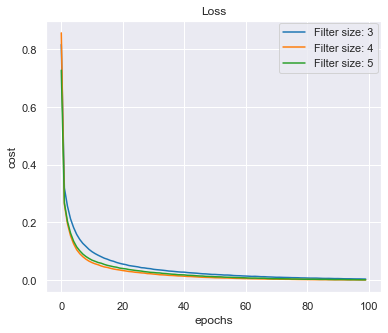

In [143]:
# Define hyperparameter set:
filter_size = [3,4,5]

# Run algorithm for comparison: 
FS_dic, FS_dic_durarion = Hyperparam_explore(hyperparams = filter_size, hyp_exp = 'f', 
                                             default_model = default, default_hyp = default_hyp)


# Plot runs with different hyperparameters:
plot_loss_compare(FS_dic, filter_size, FS_dic_durarion, compare = "filter size: ")


##### Discussion: 
The size of the filter has almost no eefect onn the model's performance. We can see a slight improvement in the test accuracy.
But, we can see that the filter size has a direct impact on the computational cost. 

##### Conclusion: 
We will stay with the default settings regarding the filter size value.

#### Padding type:

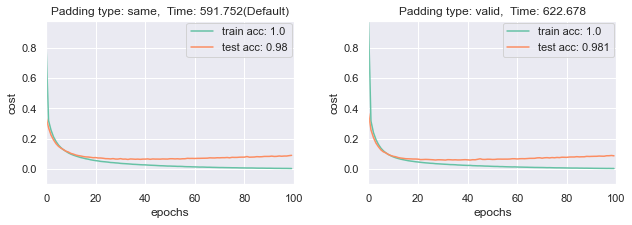

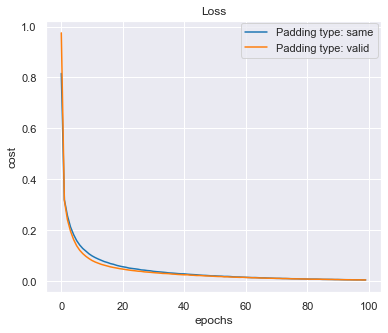

In [144]:
# Define hyperparameter set:
padding = ['same','valid']

# Run algorithm for comparison: 
Pad_dic, Pad_dic_durarion = Hyperparam_explore(hyperparams = padding, hyp_exp = 'pad', 
                                               default_model = default, default_hyp = default_hyp)

# Plot runs with different hyperparameters:
plot_loss_compare(Pad_dic, padding, Pad_dic_durarion, compare = "Padding type: ")

##### Discussion: 
for this data set Padding makes no difference.  

##### Conclusion: 
Let's stay with the default settings for Padding 

#### Stride:

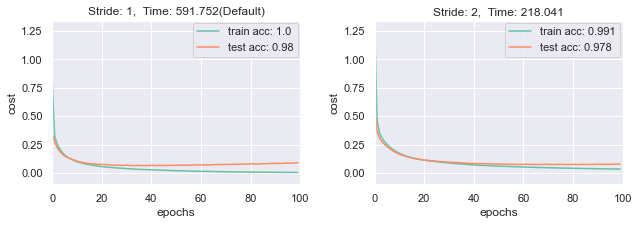

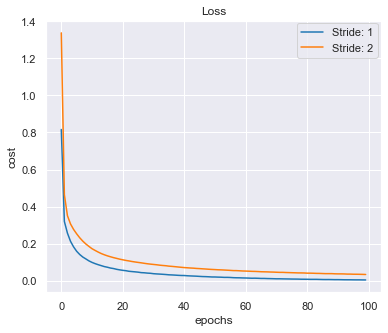

In [145]:
# Define hyperparameter set:
strides = [1,2]

# Run algorithm for comparison: 
Stide_dic, Stide_dic_durarion = Hyperparam_explore(hyperparams = strides, hyp_exp = 'stride', 
                                                   default_model = default, default_hyp = default_hyp)

# Plot runs with different hyperparameters:
plot_loss_compare(Stide_dic, strides, Stide_dic_durarion, compare = "Stride: ")

##### Discussion: 
Stride = 2 computes faster but results with poorer train accuracy, this a direct result of less parameters/featues that are computed with this type of filters , we can also see more bias in the loss. In the test set the 2 models reached almost the same results, so even if in stride = 2 there is less ovefitting it is only because the train loss is higher.  

##### Conclusion: 
Let's stay with the default settings for stride = 1, and we will deal with the overfitting problem later.  

#### Optimizer Type: 

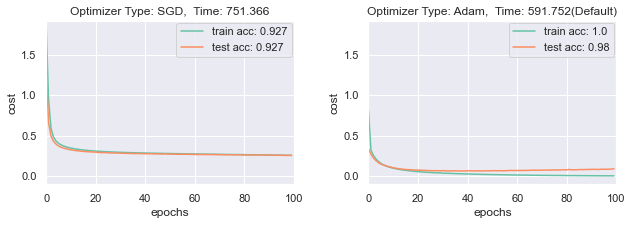

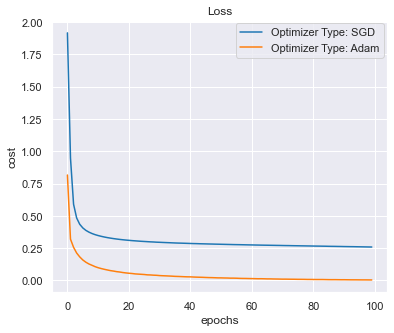

In [146]:
# Define hyperparameter set:
optimizers = ['SGD','Adam']

# Run algorithm for comparison: 
Opt_dic, Opt_dic_durarion = Hyperparam_explore(hyperparams = optimizers, hyp_exp = 'opt', 
                                               default_model = default, default_hyp = default_hyp)

# Plot runs with different hyperparameters:
plot_loss_compare(Opt_dic, optimizers, Opt_dic_durarion, compare = "Optimizer Type: ")

##### Discussion: 
By comparing the two optimizers we can see a very different behavior between the runs. The regular Gradient descent optimizer generalize well between the train and the test sets but results with a big bias. The Adam optimizer achieves much better results but still has a small overfitting. The reason why Adam optimizer manages to achieve better result is because of the momentum behavior that takes care of the stochastic descent of the gradient due to backpropagating through small mini batches. 

##### Conclusion: 
Let's stay with the default settings for Adam optimizer. 

#### Mini Batch size: 

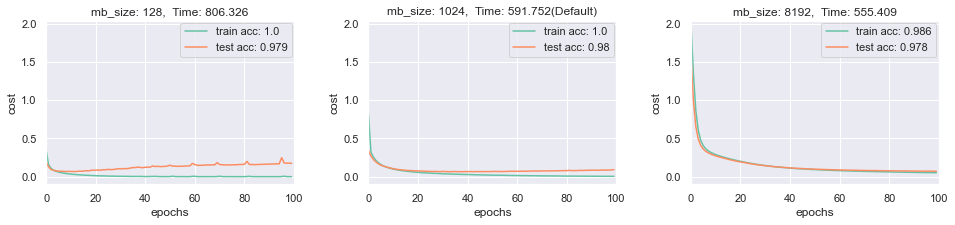

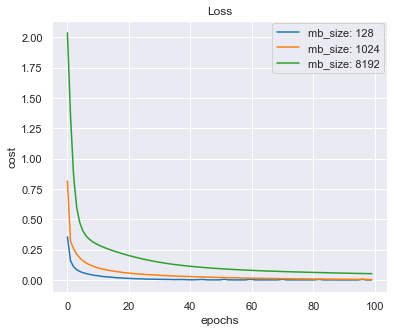

In [147]:
# Define hyperparameter set:
MB_size = [128,1024,8192]

# Run algorithm for comparison: 
MB_dic, MB_dic_durarion = Hyperparam_explore(hyperparams = MB_size, hyp_exp = 'mb_size', 
                                             default_model = default, default_hyp = default_hyp)

# Plot runs with different hyperparameters:
plot_loss_compare(MB_dic, MB_size, MB_dic_durarion, compare = "mb_size: ")

##### Discussion: 
In this experiment we can see the influence of the mini batch size regarding the bias/variance tradeoff. For small mini batch size we get bigger overfitting, and for larger minibatch size we get small overfitting but bigger bias. For our current settings, the bias/variance tradeoff is in the best spot. 

##### Conclusion: 
Let's stay with the default settings for mini batch size.

#### Dropout: 

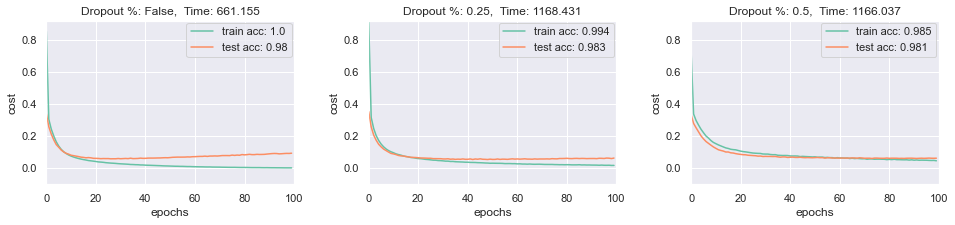

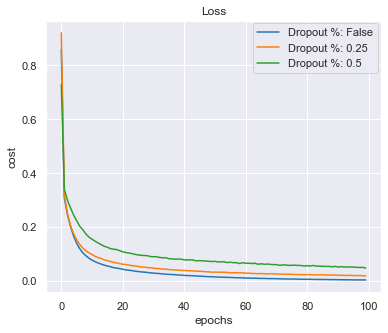

In [203]:
# Define hyperparameter set:
drops = [False, 0.25, 0.5]

# Run algorithm for comparison: 
drop_dic, drop_dic_durarion = Hyperparam_explore(hyperparams = drops, hyp_exp = 'drop', 
                                                 default_model = default, default_hyp = default_hyp)

# Plot runs with different hyperparameters:
plot_loss_compare(drop_dic, drops, drop_dic_durarion, compare = "Dropout %: ")

##### Discussion: 
We can see that with a small amount of dropout we reach a better accuracy in the test set, although the accuracy of the train set is a bit less, the model sucseeds to generalize better. 

##### Conclution: 
Use dropout of 25%. 

### Final Model

The final model was chosen to be the default model with an addition of Dropout of 25%. There are more hyperparameters to try, Learning rate, Bach normalization, and other network architecture but for now it's enough. let's run the final model, save it's parameters, explore some misslabeled examples and move on to the next project. 

In [206]:
# Define Net:
conv_model = Sequential()

# Add a convolutional layer: 
conv_model.add(Conv2D(filters = 10, kernel_size = 3, activation = 'relu', 
               input_shape = (img_size, img_size, 1), padding = 'same', strides = 1)) 

# Add dropuot: 
conv_model.add(Dropout(0.25))

# Flatten the output of the convolutional layer
conv_model.add(Flatten())

# Add an output layer for the 3 categories
conv_model.add(Dense(10, activation='softmax'))

# Compile model
conv_model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Fit model
conv_Callback = conv_model.fit(X_conv, y_keras, batch_size = 1024, epochs = 100,
                         validation_data = (X_conv_test, y_test_keras), verbose = 0)


In [236]:
preds = conv_model.predict(X_conv_test)
labels_preds = np.argmax(preds,axis=1)

In [248]:
# Retreive predictions from probabilities:
labels_preds = np.argmax(preds,axis=1)

# Find misslabeled examples from test set:
mistakes = labels_test-labels_preds
mistakes = np.where(mistakes!=0)[0]


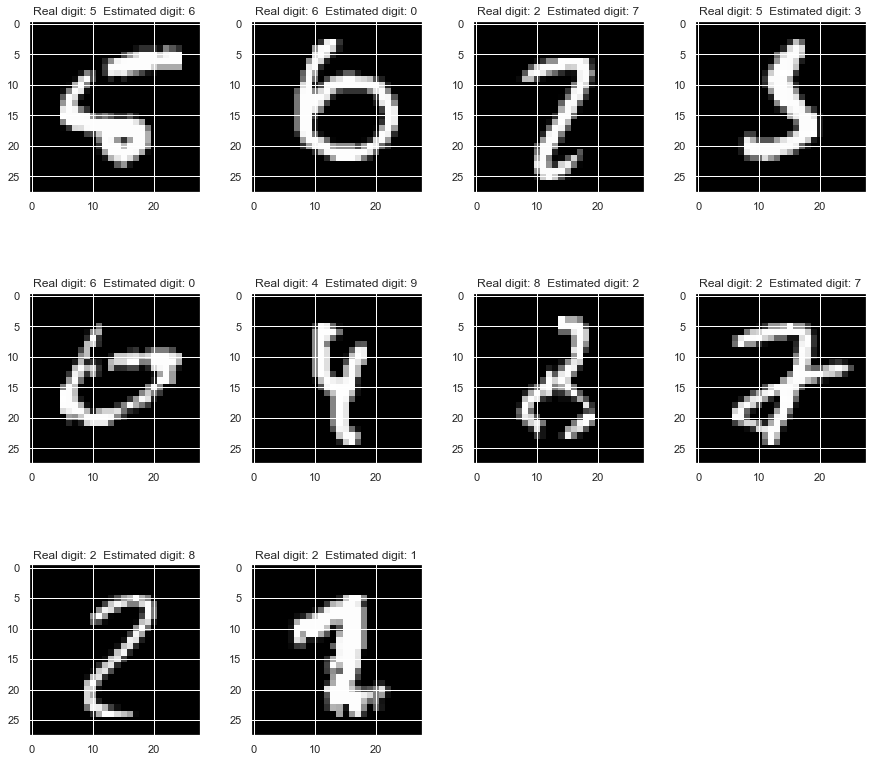

In [348]:
def plot_mistake(mistakes):
    L = len(mistakes)  
    
    fig = plt.figure(figsize = (15, 15))
    fig.subplots_adjust(hspace = 0, wspace = 0.3)
    
    for i in range(L):
        
        ax = fig.add_subplot(np.ceil(L/4),4,i+1)        
        example = X_test[:,mistakes[i]]
        example = np.reshape(example, (28,28))
        ax = plt.imshow(example,cmap='gray')
        plt.title('Real digit: ' + str(labels_test[mistakes[i]]) + '  Estimated digit: ' + str(labels_preds[mistakes[i]]))
        
    plt.show()

plot_mistake(mistakes[0:10])